In [1]:
import numpy as np
from paddleocr import PaddleOCR

ocr = PaddleOCR()  # need to run only once to load model into memory


def ocr_as_checker(image_path):
    """
    Performs OCR on the image and returns the mean confidence score.

    Args:
        image_path (str): Path to the image file.

    Returns:
        float: Mean confidence score of the OCR result. Returns 0 if no text is detected.
    """
    result = ocr.ocr(image_path, cls=False)
    confidences = []
    for res in result:
        if res is not None:  # Check if res is None
            for line in res:
                confidences.append(line[1][1])
    if confidences:
        return np.median(confidences)
    else:
        return 0  # Return 0 if no text is detected

/home/teron/miniconda3/lib/python3.12/site-packages/paddle/utils/cpp_extension/extension_utils.py:711: UserWarning: No ccache found. Please be aware that recompiling all source files may be required. You can download and install ccache from: https://github.com/ccache/ccache/blob/master/doc/INSTALL.md
  warnings.warn(warning_message)


[2025/02/21 09:30:10] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=True, use_xpu=False, use_npu=False, use_mlu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, gpu_id=0, image_dir=None, page_num=0, det_algorithm='DB', det_model_dir='/home/teron/.paddleocr/whl/det/ch/ch_PP-OCRv4_det_infer', det_limit_side_len=960, det_limit_type='max', det_box_type='quad', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, rec_algorithm='SVTR_LCNet', rec_model_dir='/home/teron/.paddleocr/whl/rec/ch/ch_PP-OCRv4_rec_infer', rec_image_inverse=True, rec_image_shape='3, 48, 320', rec_batch_num=6, max_text_lengt

In [2]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

from structured_ocr.preprocess import (
    adjust_contrast,
    adjust_whitebalance,
    denoise_image,
    deskew_image,
)

# Create output directory if it doesn't exist
output_dir = Path("../data/processed_images")
output_dir.mkdir(exist_ok=True)

# Store metrics for each image before and after processing
metrics_data = {}

for image_path in Path("../images").iterdir():
    image = Image.open(image_path)
    image_filename = image_path.stem + image_path.suffix

    print(f"Processing Image: {image_filename}")

    # Save original image metrics
    print(f"Original Image of {image_filename}:")
    original_metrics = ocr_as_checker(str(image_path))
    print(original_metrics)

    # Deskew and save
    deskewed_image = deskew_image(image)
    deskewed_path = output_dir / f"deskewed_{image_filename}"
    deskewed_image.save(deskewed_path)
    deskewed_metrics = ocr_as_checker(str(deskewed_path))
    print(deskewed_metrics)

    # Apply auto white balance and save
    print(f"Applying Auto White Balance on {image_filename}:")
    adjust_whitebalance_image = adjust_whitebalance(deskewed_image, percentile=99)
    wb_path = output_dir / f"whitebalanced_{image_filename}"
    adjust_whitebalance_image.save(wb_path)
    adjust_whitebalance_metrics = ocr_as_checker(str(wb_path))
    print(adjust_whitebalance_metrics)

    # Apply contrast increase and save
    print(f"Applying Contrast Increase on {image_filename}:")
    contrast_increase_image = adjust_contrast(adjust_whitebalance_image, contrast=1.15)
    contrast_path = output_dir / f"contrast_{image_filename}"
    contrast_increase_image.save(contrast_path)
    contrast_increase_metrics = ocr_as_checker(str(contrast_path))
    print(contrast_increase_metrics)

    # Apply denoising and save
    print(f"Applying Denoising on {image_filename}:")
    denoised_image = denoise_image(contrast_increase_image)
    denoised_path = output_dir / f"denoised_{image_filename}"
    denoised_image.save(denoised_path)
    denoised_metrics = ocr_as_checker(str(denoised_path))
    print(denoised_metrics)

    # Store metrics for this image
    metrics_data[image_path.stem] = {
        "original": original_metrics,
        "deskewed": deskewed_metrics,
        "adjust_whitebalance": adjust_whitebalance_metrics,
        "contrast_increase": contrast_increase_metrics,
        "denoised": denoised_metrics,
    }

Processing Image: perspective.jpg
Original Image of perspective.jpg:
[2025/02/21 09:30:13] ppocr DEBUG: dt_boxes num : 72, elapsed : 1.2515325546264648
[2025/02/21 09:30:14] ppocr DEBUG: rec_res num  : 72, elapsed : 0.5248792171478271
0.808030366897583
[2025/02/21 09:30:14] ppocr DEBUG: dt_boxes num : 225, elapsed : 0.1350388526916504
[2025/02/21 09:30:15] ppocr DEBUG: rec_res num  : 225, elapsed : 0.5563347339630127
0.7480208277702332
Applying Auto White Balance on perspective.jpg:
[2025/02/21 09:30:15] ppocr DEBUG: dt_boxes num : 170, elapsed : 0.0858767032623291
[2025/02/21 09:30:15] ppocr DEBUG: rec_res num  : 170, elapsed : 0.4501810073852539
0.7479978203773499
Applying Contrast Increase on perspective.jpg:
[2025/02/21 09:30:16] ppocr DEBUG: dt_boxes num : 117, elapsed : 0.07474160194396973
[2025/02/21 09:30:16] ppocr DEBUG: rec_res num  : 117, elapsed : 0.30875706672668457
0.7630512118339539
Applying Denoising on perspective.jpg:
[2025/02/21 09:30:16] ppocr DEBUG: dt_boxes num : 

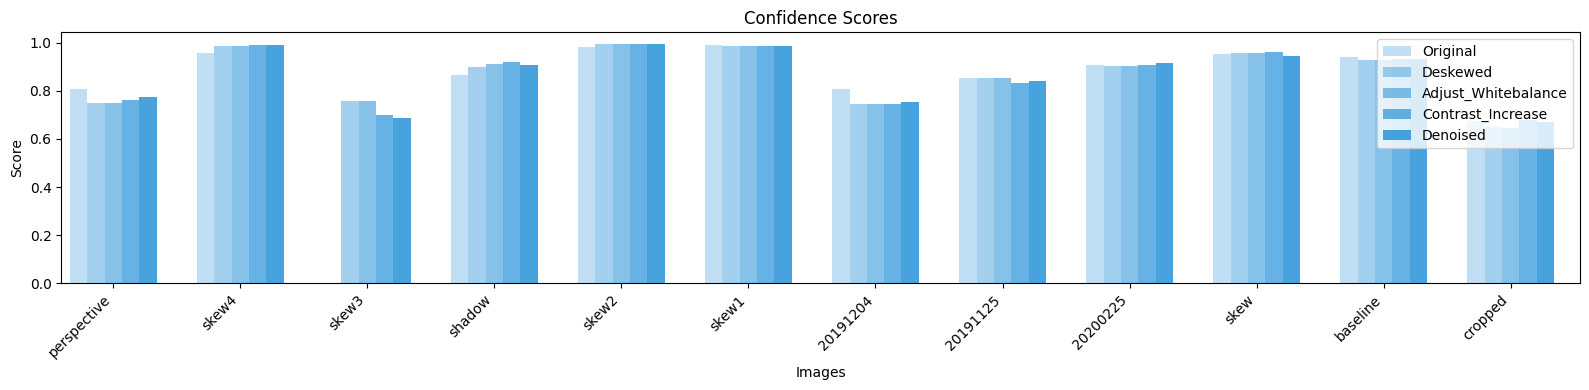

In [3]:
import matplotlib.pyplot as plt
import numpy as np

processing_types = list(next(iter(metrics_data.values())).keys())

# Create plot for quality scores
fig, ax = plt.subplots(figsize=(16, 4))

# Set up bar positions with wider spacing between groups
num_images = len(metrics_data)
bar_width = 0.15  # Reduced bar width
group_spacing = 0.1  # Added spacing between groups
x = np.arange(num_images) * (1 + group_spacing)  # Spread out the x positions

# Plot bars for each processing type
alphas = np.linspace(0.3, 0.9, len(processing_types))
for i, (proc_type, alpha) in enumerate(zip(processing_types, alphas)):
    scores = []
    for image_name, image_data in metrics_data.items():
        scores.append(image_data[proc_type])

    ax.bar(x + i * bar_width, scores, width=bar_width, label=proc_type.title(), color="#3498db", alpha=alpha)

# Customize plot
ax.set_title("Confidence Scores")
ax.set_xlabel("Images")
ax.set_ylabel("Score")
ax.set_xticks(x + bar_width * (len(processing_types) - 1) / 2)
ax.set_xticklabels(list(metrics_data.keys()), rotation=45, ha="right")
ax.legend()

# Adjust plot limits to account for wider spacing
ax.set_xlim(-bar_width, x[-1] + bar_width * len(processing_types) + bar_width)

plt.tight_layout()
plt.show()